# PLAN

- [ ] Acquisition
    - [x] read the csv into a dataframe
- [ ] Preparation
    - [ ] no missing values
    - [ ] drop columns that are not needed
    - [x] change case to lower case
    - [ ] make sure everything has right dtype
    - [ ] normalize what needs to be normalized
    - [x] rename columns for clarification
- [ ] Exploration
    - [ ] answer ALL questions raised
        - [x] Which locations are the most frequent sites of SSO?
        - [x] Which location have the most volume of overflow?
        - [x] What are most common root causes of SSO?
        - [x] Where do the majority of overflow go?

    - [ ] visualize important findings
    - [ ] decide what TODO items to keep
- [ ] Modeling
    - [ ] predict 
- [ ] Delivery
    - [ ] report
    - [ ] prezi slides
    - [ ] website

# ENVIRONMENT

In [1]:
import os
import acquire
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm

from datetime import timedelta, datetime
from pylab import rcParams

# ACQUIRE

_Let's read in the data from the csv file and take a peek at te first five records._

In [2]:
df = acquire.read_data('saws-ssos.csv')

In [3]:
df.head()

,SSO_ID,INSPKEY,SERVNO,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,...,Root_Cause,STEPS_TO_PREVENT,SPILL_START_2,SPILL_STOP_2,HRS_2,GAL_2,SPILL_START_3,SPILL_STOP_3,HRS_3,GAL_3
0,6582,567722.0,NaN,3/10/19,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
1,6583,567723.0,NaN,3/10/19,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
2,6581,567714.0,NaN,3/9/19,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,...,NaN,NaN,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0
3,6584,567713.0,NaN,3/9/19,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
4,6580,567432.0,NaN,3/6/19,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0


# PREPARE

In [4]:
def missing_values_col(df):
    """
    This functions returns the total missing values and
    the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})


def missing_values_row(df):
    """
    This functions returns the total missing values and
    the percent missing values by row.
    """
    null_count = df.isnull().sum(axis=1)
    null_percentage = (null_count / df.shape[1]) * 100
    return pd.DataFrame({'num_missing': null_count, 'percentage': null_percentage})


def handle_missing_threshold(df, prop_required_column = .3, prop_required_row = .9):
    """
    This functions removes columns and rows whose
    count of missing values exceeds threshold.
    """
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def count_values(df):
    """
    This function counts the value of columns in a dataframe.
    """
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f"{col}:")
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False))
        else:
            print(df[col].value_counts())
        print("\n")

def remove_columns(df, columns):
    return df.drop(columns=columns)


def fill_with_zeroes(df, *cols):
    """
    This functions returns the column names as input and
    return the dataframe with the
    null values in those columns replace by 0.
    """
    for col in cols:
        df[col] = df[col].fillna(0)
    return df


def fill_with_median(df, *cols):
    """
    This function fills the NaN values with
    respective median values.
    """
    for col in cols:
        df[col] = df[col].fillna(df[col].median())
    return df


def fill_with_none(df, *cols):
    """
    This function fills the NaN values with
    'None' string value.
    """
    for col in cols:
        df[col] = df[col].fillna('None')
    return df

def fill_with_unknown(df, *cols):
    """
    This functions fills the NaN values with
    'Unknown' string value.
    """
    for col in cols:
        df[col] = df[col].fillna('Unknown')
    return df

def lowercase_columm(df, *columns):
    """
    This function returns a lowercase version of the column values.
    """
    for col in columns:
        df[col] = df[col].str.lower() 
    return df

_Let's convert the column to lowercase to make them easier to work with._

In [5]:
df.columns = map(str.lower, df.columns)
df.head()

,sso_id,inspkey,servno,reportdate,spill_address,spill_st_name,total_gal,galsret,gal,spill_start,...,root_cause,steps_to_prevent,spill_start_2,spill_stop_2,hrs_2,gal_2,spill_start_3,spill_stop_3,hrs_3,gal_3
0,6582,567722.0,NaN,3/10/19,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
1,6583,567723.0,NaN,3/10/19,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
2,6581,567714.0,NaN,3/9/19,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,...,NaN,NaN,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0
3,6584,567713.0,NaN,3/9/19,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
4,6580,567432.0,NaN,3/6/19,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,...,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0


_Let's take a look at the missing values._

In [6]:
missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
sso_id,0,0.000000,0,0.000000,0,0.0
inspkey,797,25.039271,0,0.000000,0,0.0
servno,2715,85.296890,0,0.000000,0,0.0
reportdate,0,0.000000,0,0.000000,0,0.0
spill_address,0,0.000000,0,0.000000,0,0.0
spill_st_name,0,0.000000,0,0.000000,0,0.0
total_gal,0,0.000000,0,0.000000,0,0.0
galsret,475,14.923029,0,0.000000,0,0.0
gal,0,0.000000,0,0.000000,0,0.0
spill_start,0,0.000000,0,0.000000,0,0.0


_Let's look at a few of the rows._

In [7]:
df.head(7).T

,0,1,2,3,4,5,6
sso_id,6582,6583,6581,6584,6580,6579,6577
inspkey,567722,567723,567714,567713,567432,567274,567046
servno,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reportdate,3/10/19,3/10/19,3/9/19,3/9/19,3/6/19,3/5/19,3/2/19
spill_address,3200,6804,215,3602,100,3200,9910
spill_st_name,THOUSAND OAKS DR,S FLORES ST,AUDREY ALENE DR,SE MILITARY DR,PANSY LN,S HACKBERRY ST,SUGARLOAF DR
total_gal,2100,80,79,83,75,250,73
galsret,2100,0,0,0,0,0,0
gal,2100,80,10,83,75,250,73
spill_start,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM,3/6/2019 9:40:00 AM,3/5/2019 2:22:00 PM,3/2/2019 1:42:00 PM


_Now let's take a peek into the value counts of the columns._

In [8]:
count_values(df)

sso_id:
(-5.5840000000000005, 659.3]    310
(659.3, 1317.6]                  38
(1317.6, 1975.9]                326
(1975.9, 2634.2]                644
(2634.2, 3292.5]                587
(3292.5, 3950.8]                464
(3950.8, 4609.1]                  0
(4609.1, 5267.4]                  6
(5267.4, 5925.7]                157
(5925.7, 6584.0]                651
Name: sso_id, dtype: int64


inspkey:
(3724.564, 60631.5]     541
(60631.5, 116975.0]     372
(116975.0, 173318.5]    392
(173318.5, 229662.0]    246
(229662.0, 286005.5]    134
(286005.5, 342349.0]    174
(342349.0, 398692.5]    118
(398692.5, 455036.0]    125
(455036.0, 511379.5]    151
(511379.5, 567723.0]    133
Name: inspkey, dtype: int64


servno:
(274101.378, 515352.1]     18
(515352.1, 754214.2]       14
(754214.2, 993076.3]       72
(993076.3, 1231938.4]      38
(1231938.4, 1470800.5]    101
(1470800.5, 1709662.6]     62
(1709662.6, 1948524.7]     20
(1948524.7, 2187386.8]     17
(2187386.8, 2426248.9]     31
(24262

120.0    321
12.0     169
24.0     165
6.0       63
3.0       37
60.0      23
1.0       12
Name: timeint, dtype: int64


root_cause:
STRUCTURAL           1237
GREASE                610
DEBRIS                443
RAIN EVENT            353
CONTRACTOR            164
LIFT STATION          125
OTHER                  61
VANDALISM              48
RAIN EVENT             48
VANDALISM              24
ROOTS                  22
LIFT STATION           15
I/I                    12
CONTRACTOR              8
BY PASS PUMP LEAK       3
Grease                  1
Debris                  1
OTHER                   1
Name: root_cause, dtype: int64


steps_to_prevent:
Increase FCS,         470
Point Repair,         280
Design Request,       201
Other                 195
I/I Inv,              144
Capacity Project,     114
Bolt down,             24
ED/COM,                11
RPC,                    7
Name: steps_to_prevent, dtype: int64


spill_start_2:
06/02/2016 20:00    2
03/28/2018 18:28    1
11/09/2016 07:45

_Let's rename the columns for clarity._

In [9]:
df = df.rename(index=str, columns={'inspkey':'inspection_key',
                                   'servno':'service_number',
                                   'reportdate':'report_date',
                                   'spill_st_name':'spill_street_name',
                                   'total_gal':'total_gallons',
                                   'galsret':'gallons_returned',
                                   'gal':'gallons_1',
                                   'spill_start':'spill_start_1',
                                   'spill_stop':'spill_stop_1',
                                   'hrs':'hours_1',
                                   'unitid':'unit_id_1',
                                   'unitid2':'unit_id_2',
                                   'earz_zone':'edwards_zone',
                                   'expr1029':'expr_1029',
                                   'pipediam':'pipe_diameter',
                                   'pipelen':'pipe_length',
                                   'pipetype':'pipe_type',
                                   'instyear':'installation_year',
                                   'dwndpth':'downstream_depth',
                                   'upsdpth':'upstream_depth',
                                   'rainfall_less3':'rainfall_less_3',
                                   'spill address': 'spill_address_full',
                                   'sewerassetexp':'sewer_asset_exp',
                                   'prevspill_24mos':'previous_spill_24mos',
                                   'unittype':'unit_type',
                                   'assettype':'asset_type',
                                   'lastclnd':'last_cleaned',
                                   'responsetime':'response_time',
                                   'responsedttm':'response_datetime',
                                   'public notice':'public_notice',
                                   'timeint':'time_int',
                                   'hrs_2':'hours_2',
                                   'gal_2':'gallons_2',
                                   'hrs_3':'hours_3',
                                   'gal_3':'gallons_3'
                                   })

In [10]:
df.head(4).T

,0,1,2,3
sso_id,6582,6583,6581,6584
inspection_key,567722,567723,567714,567713
service_number,NaN,NaN,NaN,NaN
report_date,3/10/19,3/10/19,3/9/19,3/9/19
spill_address,3200,6804,215,3602
spill_street_name,THOUSAND OAKS DR,S FLORES ST,AUDREY ALENE DR,SE MILITARY DR
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
gallons_1,2100,80,10,83
spill_start_1,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM


## _Let's make copies of the original dataframe before dropping some columns and rows to cover scenarios where we uncover more information about the variables._

In [11]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

_Let's work with df1..._

_Let's remove columns that do not add information._

In [12]:
df1 = remove_columns(df1, columns=['sso_id',
                                   'inspection_key',
                                   'service_number',
                                   'comments',
                                   'ferguson',
                                   'expr_1029',
                                   'downstream_depth',
                                   'upstream_depth',
                                   'sewer_asset_exp',
                                   'previous_spill_24mos',
                                ])
df1.head(4).T

,0,1,2,3
report_date,3/10/19,3/10/19,3/9/19,3/9/19
spill_address,3200,6804,215,3602
spill_street_name,THOUSAND OAKS DR,S FLORES ST,AUDREY ALENE DR,SE MILITARY DR
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
gallons_1,2100,80,10,83
spill_start_1,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM
spill_stop_1,3/10/2019 2:40:00 PM,3/10/2019 3:45:00 PM,3/9/2019 7:30:00 PM,3/9/2019 5:00:00 PM
hours_1,1.4,1.33333,1.5,1.38333
cause,Grease,Grease,Structural,Grease


_Let's create a new address that's prettier._

In [13]:
df1['spill_street_address'] = df1['spill_address'].map(str)+ ' ' + df1['spill_street_name']
df1.head(4).T

,0,1,2,3
report_date,3/10/19,3/10/19,3/9/19,3/9/19
spill_address,3200,6804,215,3602
spill_street_name,THOUSAND OAKS DR,S FLORES ST,AUDREY ALENE DR,SE MILITARY DR
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
gallons_1,2100,80,10,83
spill_start_1,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM
spill_stop_1,3/10/2019 2:40:00 PM,3/10/2019 3:45:00 PM,3/9/2019 7:30:00 PM,3/9/2019 5:00:00 PM
hours_1,1.4,1.33333,1.5,1.38333
cause,Grease,Grease,Structural,Grease


In [14]:
df1 = df1.drop(columns=['spill_address_full', 'spill_address', 'spill_street_name'])
df1.head(4).T

,0,1,2,3
report_date,3/10/19,3/10/19,3/9/19,3/9/19
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
gallons_1,2100,80,10,83
spill_start_1,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM
spill_stop_1,3/10/2019 2:40:00 PM,3/10/2019 3:45:00 PM,3/9/2019 7:30:00 PM,3/9/2019 5:00:00 PM
hours_1,1.4,1.33333,1.5,1.38333
cause,Grease,Grease,Structural,Grease
actions,CLEANED MAIN,CLEANED MAIN,CLEANED MAIN,NaN
watershed,SALADO CREEK,DOS RIOS,DOS RIOS,SALADO CREEK


_Let's look at the missing values._

In [15]:
missing_values_col(df1)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
report_date,0,0.000000,0,0.000000,0,0.0
total_gallons,0,0.000000,0,0.000000,0,0.0
gallons_returned,475,14.923029,0,0.000000,0,0.0
gallons_1,0,0.000000,0,0.000000,0,0.0
spill_start_1,0,0.000000,0,0.000000,0,0.0
spill_stop_1,0,0.000000,0,0.000000,0,0.0
hours_1,3,0.094251,0,0.000000,0,0.0
cause,0,0.000000,0,0.000000,0,0.0
actions,8,0.251335,0,0.000000,0,0.0
watershed,0,0.000000,0,0.000000,0,0.0


_Make new variable of whether this incident involved two or more spills within 24 hours._

In [16]:
df1['multiple_spills'] = np.where(df1['spill_start_2'].isnull(), False, True)
df1

,report_date,total_gallons,gallons_returned,gallons_1,spill_start_1,spill_stop_1,hours_1,cause,actions,watershed,...,spill_start_2,spill_stop_2,hours_2,gallons_2,spill_start_3,spill_stop_3,hours_3,gallons_3,spill_street_address,multiple_spills
0,3/10/19,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,1.400000,Grease,CLEANED MAIN,SALADO CREEK,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,3200 THOUSAND OAKS DR,False
1,3/10/19,80,0.0,80.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,1.333333,Grease,CLEANED MAIN,DOS RIOS,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,6804 S FLORES ST,False
2,3/9/19,79,0.0,10.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,1.500000,Structural,CLEANED MAIN,DOS RIOS,...,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0,215 AUDREY ALENE DR,True
3,3/9/19,83,0.0,83.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,1.383333,Grease,NaN,SALADO CREEK,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,3602 SE MILITARY DR,False
4,3/6/19,75,0.0,75.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,0.250000,Structural,CLEANED MAIN,SALADO CREEK,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,100 PANSY LN,False
5,3/5/19,250,0.0,250.0,3/5/2019 2:22:00 PM,3/5/2019 2:32:00 PM,0.166667,Grease,CLEANED MAIN,DOS RIOS,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,3200 S HACKBERRY ST,False
6,3/2/19,73,0.0,73.0,3/2/2019 1:42:00 PM,3/2/2019 2:55:00 PM,1.216667,Grease,CLEANED MAIN,MEDIO CREEK,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,9910 SUGARLOAF DR,False
7,3/1/19,76,0.0,76.0,3/1/2019 6:34:00 PM,3/1/2019 7:50:00 PM,1.266667,Grease,CLEANED MAIN,DOS RIOS,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,3507 PIEDMONT AVE,False
8,2/26/19,3750,0.0,3750.0,2/26/2019 9:00:00 AM,2/26/2019 10:15:00 AM,1.250000,Structural,CLEANED MAIN,LEON CREEK,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,349 ALICIA,False
9,2/26/19,66,0.0,66.0,2/26/2019 5:24:00 PM,2/26/2019 6:30:00 PM,1.100000,Grease,CLEANED MAIN,DOS RIOS,...,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0,1502 W MISTLETOE AVE,False


_Now that we'vew made the multiple spills variable, we can remove redundant columns._

In [17]:
df1 = df1.drop(columns=['spill_start_2',
                        'spill_stop_2',
                        'hours_2',
                        'gallons_2',
                        'spill_start_3',
                        'spill_stop_3',
                        'hours_3',
                        'gallons_3',
                        'gallons_1'
                     ])
df1

,report_date,total_gallons,gallons_returned,spill_start_1,spill_stop_1,hours_1,cause,actions,watershed,unit_id_1,...,asset_type,last_cleaned,response_time,response_datetime,public_notice,time_int,root_cause,steps_to_prevent,spill_street_address,multiple_spills
0,3/10/19,2100,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,1.400000,Grease,CLEANED MAIN,SALADO CREEK,66918,...,Sewer Main,NaN,0.45,10-Mar-19,False,24.0,NaN,NaN,3200 THOUSAND OAKS DR,False
1,3/10/19,80,0.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,1.333333,Grease,CLEANED MAIN,DOS RIOS,24250,...,Sewer Main,NaN,1.08,10-Mar-19,False,120.0,NaN,NaN,6804 S FLORES ST,False
2,3/9/19,79,0.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,1.500000,Structural,CLEANED MAIN,DOS RIOS,2822,...,Sewer Main,NaN,1.00,09-Mar-19,False,24.0,NaN,NaN,215 AUDREY ALENE DR,True
3,3/9/19,83,0.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,1.383333,Grease,NaN,SALADO CREEK,92804,...,Sewer Main,NaN,0.55,09-Mar-19,False,120.0,NaN,NaN,3602 SE MILITARY DR,False
4,3/6/19,75,0.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,0.250000,Structural,CLEANED MAIN,SALADO CREEK,61141,...,Sewer Main,NaN,0.00,06-Mar-19,False,3.0,NaN,NaN,100 PANSY LN,False
5,3/5/19,250,0.0,3/5/2019 2:22:00 PM,3/5/2019 2:32:00 PM,0.166667,Grease,CLEANED MAIN,DOS RIOS,38907,...,Sewer Main,NaN,0.00,05-Mar-19,False,12.0,NaN,NaN,3200 S HACKBERRY ST,False
6,3/2/19,73,0.0,3/2/2019 1:42:00 PM,3/2/2019 2:55:00 PM,1.216667,Grease,CLEANED MAIN,MEDIO CREEK,85120,...,Sewer Main,NaN,0.73,02-Mar-19,False,120.0,GREASE,"Increase FCS,",9910 SUGARLOAF DR,False
7,3/1/19,76,0.0,3/1/2019 6:34:00 PM,3/1/2019 7:50:00 PM,1.266667,Grease,CLEANED MAIN,DOS RIOS,26128,...,Sewer Main,NaN,0.43,01-Mar-19,False,120.0,NaN,"Increase FCS,",3507 PIEDMONT AVE,False
8,2/26/19,3750,0.0,2/26/2019 9:00:00 AM,2/26/2019 10:15:00 AM,1.250000,Structural,CLEANED MAIN,LEON CREEK,47292,...,Sewer Main,NaN,0.00,26-Feb-19,False,120.0,STRUCTURAL,"Design Request,",349 ALICIA,False
9,2/26/19,66,0.0,2/26/2019 5:24:00 PM,2/26/2019 6:30:00 PM,1.100000,Grease,CLEANED MAIN,DOS RIOS,14241,...,Sewer Main,NaN,0.43,26-Feb-19,False,120.0,DEBRIS,"Increase FCS,",1502 W MISTLETOE AVE,False


_Now that we've removed redundant columns, we can now rename the following spill details into simpler names._

In [18]:
df1 = df1.rename(index=str, columns={"spill_start_1": "spill_start",
                               "spill_stop_1": "spill_stop",
                               "hours_1": "hours"})

_Let's make the fields lowercase as well..._

In [19]:
df1 = lowercase_columm(df1, 'unit_type',
                 'asset_type',
                 'cause',
                 'actions',
                 'watershed',
                 'discharge_to',
                 'discharge_route',
                 'pipe_type',
                 'root_cause',
                 'spill_street_address'
                )
df1.head(4).T

,0,1,2,3
report_date,3/10/19,3/10/19,3/9/19,3/9/19
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
spill_start,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM
spill_stop,3/10/2019 2:40:00 PM,3/10/2019 3:45:00 PM,3/9/2019 7:30:00 PM,3/9/2019 5:00:00 PM
hours,1.4,1.33333,1.5,1.38333
cause,grease,grease,structural,grease
actions,cleaned main,cleaned main,cleaned main,NaN
watershed,salado creek,dos rios,dos rios,salado creek
unit_id_1,66918,24250,2822,92804


_Let's assign a variable with all numerical column names._

In [20]:
numerical_columns = list(df1.select_dtypes(include=[np.number]).columns.values)
numerical_columns

['total_gallons',
 'gallons_returned',
 'hours',
 'council_district',
 'month',
 'year',
 'week',
 'edwards_zone',
 'pipe_diameter',
 'pipe_length',
 'installation_year',
 'inches_no',
 'rainfall_less_3',
 'num_spills_compkey',
 'num_spills_24mos',
 'time_int']

_Let's assign a variable with all non-numerical column names._

In [21]:
non_numerical_columns = list(df1.select_dtypes(exclude=[np.number]).columns.values)
non_numerical_columns

['report_date',
 'spill_start',
 'spill_stop',
 'cause',
 'actions',
 'watershed',
 'unit_id_1',
 'unit_id_2',
 'discharge_to',
 'discharge_route',
 'pipe_type',
 'unit_type',
 'asset_type',
 'last_cleaned',
 'response_time',
 'response_datetime',
 'public_notice',
 'root_cause',
 'steps_to_prevent',
 'spill_street_address',
 'multiple_spills']

_Let's fix the data types?_

In [22]:
df1.dtypes

report_date              object
total_gallons             int64
gallons_returned        float64
spill_start              object
spill_stop               object
hours                   float64
cause                    object
actions                  object
watershed                object
unit_id_1                object
unit_id_2                object
discharge_to             object
discharge_route          object
council_district        float64
month                     int64
year                      int64
week                      int64
edwards_zone            float64
pipe_diameter           float64
pipe_length             float64
pipe_type                object
installation_year       float64
inches_no               float64
rainfall_less_3         float64
num_spills_compkey        int64
num_spills_24mos        float64
unit_type                object
asset_type               object
last_cleaned             object
response_time            object
response_datetime        object
public_n

# EXPLORE

### Looking for the repeat offenders...

In [23]:
df1.num_spills_24mos[df1.num_spills_24mos > 1].value_counts()

2.0     180
3.0      75
4.0      32
5.0      27
6.0      19
7.0      12
8.0       7
9.0       5
10.0      1
11.0      1
12.0      1
13.0      1
Name: num_spills_24mos, dtype: int64

### Locations of the most frequent SSOs in 2 years

In [24]:
df1[['spill_street_address']][df1.num_spills_24mos >= 9]

,spill_street_address
33,6606 swiss oaks
40,6606 swiss oaks
84,108 chappie james way
153,6606 swiss oaks
593,10800 entrance rd ne
727,10800 entrance rd ne
738,10800 entrance rd ne
751,10823 entrance rd ne
762,10700 entrance rd ne


### Total number of gallons spilled by the most frequent SSOs in 2 years

In [25]:
df1.total_gallons[df1.num_spills_24mos >= 9].agg('sum')

3538455

In [26]:
df1[['spill_street_address', 'total_gallons', 'hours', 'root_cause',
     'unit_type', 'asset_type', 'last_cleaned', 'multiple_spills',
     'discharge_to', 'discharge_route']][df1.num_spills_24mos >= 9]

,spill_street_address,total_gallons,hours,root_cause,unit_type,asset_type,last_cleaned,multiple_spills,discharge_to,discharge_route
33,6606 swiss oaks,48000,4.000000,rain event,outfall,sewer main,NaN,False,creek bed - spilled into leon creek,leon creek
40,6606 swiss oaks,815355,63.930000,rain event,outfall,sewer main,NaN,False,creek bed - spilled into leon creek,leon creek
84,108 chappie james way,2448400,95.650000,rain event,outfall,sewer main,NaN,False,creek bed - spilled into leon creek,leon creek
153,6606 swiss oaks,123300,5.250000,rain event,outfall,sewer main,NaN,False,creek bed - spilled into leon creek,leon creek
593,10800 entrance rd ne,12000,4.000000,rain event,gravity,sewer main,NaN,False,creek bed - spilled into salado creek,salado creek
727,10800 entrance rd ne,78000,8.666667,rain event,gravity,sewer main,NaN,False,creek bed - spilled into salado creek,none
738,10800 entrance rd ne,100,0.250000,other,gravity,sewer main,NaN,False,ground,none
751,10823 entrance rd ne,200,0.166667,by pass pump leak,gravity,sewer main,NaN,False,ground,none
762,10700 entrance rd ne,13100,1.450000,other,gravity,sewer main,NaN,True,ground,salado creek


### Most common root causes of SSOs

In [27]:
df1.root_cause.value_counts()

structural           1237
grease                611
debris                444
rain event            353
contractor            164
lift station          125
other                  61
rain event             48
vandalism              48
vandalism              24
roots                  22
lift station           15
i/i                    12
contractor              8
by pass pump leak       3
other                   1
Name: root_cause, dtype: int64

- [ ] **TODO:** Find a way to flesh out the address using regex to account for typos etc.
- [ ] **TODO:** Maybe try using unit id's instead of addresses.
- [ ] **TODO:** Drill down to only the top 3-5 locations.
- [ ] **TODO:** Compare predictions between preventing SSO on the most frequents versus not preventing.
- [ ] **TODO:** What is causing the spills on these top 3-5 locations?

In [28]:
df1.head(4).T

,0,1,2,3
report_date,3/10/19,3/10/19,3/9/19,3/9/19
total_gallons,2100,80,79,83
gallons_returned,2100,0,0,0
spill_start,3/10/2019 1:16:00 PM,3/10/2019 2:25:00 PM,3/9/2019 6:00:00 PM,3/9/2019 3:37:00 PM
spill_stop,3/10/2019 2:40:00 PM,3/10/2019 3:45:00 PM,3/9/2019 7:30:00 PM,3/9/2019 5:00:00 PM
hours,1.4,1.33333,1.5,1.38333
cause,grease,grease,structural,grease
actions,cleaned main,cleaned main,cleaned main,NaN
watershed,salado creek,dos rios,dos rios,salado creek
unit_id_1,66918,24250,2822,92804


In [29]:
df1[['spill_street_address', 'unit_id_1','unit_id_2', 'unit_type', 'asset_type']].head(15)

,spill_street_address,unit_id_1,unit_id_2,unit_type,asset_type
0,3200 thousand oaks dr,66918,66917,gravity,sewer main
1,6804 s flores st,24250,24193,gravity,sewer main
2,215 audrey alene dr,2822,3351,gravity,sewer main
3,3602 se military dr,92804,92805,gravity,sewer main
4,100 pansy ln,61141,49543,gravity,sewer main
5,3200 s hackberry st,38907,26117,gravity,sewer main
6,9910 sugarloaf dr,85120,85363,gravity,sewer main
7,3507 piedmont ave,26128,24334,gravity,sewer main
8,349 alicia,47292,47293,gravity,sewer main
9,1502 w mistletoe ave,14241,14896,gravity,sewer main


- [ ] **TODO:** Maybe we can do some kind of clustering to group problem areas.

In [30]:
df1.unit_id_1.value_counts()[df1.unit_id_1.value_counts() > 7]

52470     15
LS200     14
1187      13
903059    12
LS199     12
62085     10
LS188     10
1210      10
47822     10
903060    10
29988      8
LS201      8
424896     8
11989      8
Name: unit_id_1, dtype: int64

In [31]:
df1.unit_id_2.value_counts()[df1.unit_id_2.value_counts() > 7]

1074      13
52677     13
71380     12
903059    10
62088      9
922726     9
46546      9
16276      8
79942      8
499663     8
424898     8
Name: unit_id_2, dtype: int64

In [32]:
df1['root_cause'].value_counts()

structural           1237
grease                611
debris                444
rain event            353
contractor            164
lift station          125
other                  61
rain event             48
vandalism              48
vandalism              24
roots                  22
lift station           15
i/i                    12
contractor              8
by pass pump leak       3
other                   1
Name: root_cause, dtype: int64

In [33]:
df1['spill_street_address'].value_counts()[df1.spill_street_address.value_counts() > 7]

6606 swiss oaks          24
108 chappie james way    20
700 holbrook             16
10800 entrance rd ne     14
6305 cagnon rd           13
23500 ih 10 w            12
6785 cagnon rd           12
1800 austin hwy          12
1427 harry wurzbach      12
668 holbrook             10
10102 us hwy 90 w         9
3847 thousand oaks        8
Name: spill_street_address, dtype: int64

### Looking for locations with most SSOs that are also caused by grease.

In [34]:
df1.columns

Index(['report_date', 'total_gallons', 'gallons_returned', 'spill_start',
       'spill_stop', 'hours', 'cause', 'actions', 'watershed', 'unit_id_1',
       'unit_id_2', 'discharge_to', 'discharge_route', 'council_district',
       'month', 'year', 'week', 'edwards_zone', 'pipe_diameter', 'pipe_length',
       'pipe_type', 'installation_year', 'inches_no', 'rainfall_less_3',
       'num_spills_compkey', 'num_spills_24mos', 'unit_type', 'asset_type',
       'last_cleaned', 'response_time', 'response_datetime', 'public_notice',
       'time_int', 'root_cause', 'steps_to_prevent', 'spill_street_address',
       'multiple_spills'],
      dtype='object')

In [35]:
df1['counts'] = df1.root_cause
df1['counts'] = df1.groupby(['spill_street_address']).transform('count')
df1

,report_date,total_gallons,gallons_returned,spill_start,spill_stop,hours,cause,actions,watershed,unit_id_1,...,last_cleaned,response_time,response_datetime,public_notice,time_int,root_cause,steps_to_prevent,spill_street_address,multiple_spills,counts
0,3/10/19,2100,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,1.400000,grease,cleaned main,salado creek,66918,...,NaN,0.45,10-Mar-19,False,24.0,NaN,NaN,3200 thousand oaks dr,False,1
1,3/10/19,80,0.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,1.333333,grease,cleaned main,dos rios,24250,...,NaN,1.08,10-Mar-19,False,120.0,NaN,NaN,6804 s flores st,False,1
2,3/9/19,79,0.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,1.500000,structural,cleaned main,dos rios,2822,...,NaN,1.00,09-Mar-19,False,24.0,NaN,NaN,215 audrey alene dr,True,1
3,3/9/19,83,0.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,1.383333,grease,NaN,salado creek,92804,...,NaN,0.55,09-Mar-19,False,120.0,NaN,NaN,3602 se military dr,False,1
4,3/6/19,75,0.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,0.250000,structural,cleaned main,salado creek,61141,...,NaN,0.00,06-Mar-19,False,3.0,NaN,NaN,100 pansy ln,False,1
5,3/5/19,250,0.0,3/5/2019 2:22:00 PM,3/5/2019 2:32:00 PM,0.166667,grease,cleaned main,dos rios,38907,...,NaN,0.00,05-Mar-19,False,12.0,NaN,NaN,3200 s hackberry st,False,1
6,3/2/19,73,0.0,3/2/2019 1:42:00 PM,3/2/2019 2:55:00 PM,1.216667,grease,cleaned main,medio creek,85120,...,NaN,0.73,02-Mar-19,False,120.0,grease,"Increase FCS,",9910 sugarloaf dr,False,1
7,3/1/19,76,0.0,3/1/2019 6:34:00 PM,3/1/2019 7:50:00 PM,1.266667,grease,cleaned main,dos rios,26128,...,NaN,0.43,01-Mar-19,False,120.0,NaN,"Increase FCS,",3507 piedmont ave,False,2
8,2/26/19,3750,0.0,2/26/2019 9:00:00 AM,2/26/2019 10:15:00 AM,1.250000,structural,cleaned main,leon creek,47292,...,NaN,0.00,26-Feb-19,False,120.0,structural,"Design Request,",349 alicia,False,1
9,2/26/19,66,0.0,2/26/2019 5:24:00 PM,2/26/2019 6:30:00 PM,1.100000,grease,cleaned main,dos rios,14241,...,NaN,0.43,26-Feb-19,False,120.0,debris,"Increase FCS,",1502 w mistletoe ave,False,1


### Below shows the most frequent SSOs that are caused by grease.

In [36]:
df1.loc[(df1['counts'] >= 7) & (df1['root_cause'] == 'grease')]

,report_date,total_gallons,gallons_returned,spill_start,spill_stop,hours,cause,actions,watershed,unit_id_1,...,last_cleaned,response_time,response_datetime,public_notice,time_int,root_cause,steps_to_prevent,spill_street_address,multiple_spills,counts
171,8/12/18,75000,NaN,8/12/2018 4:15:00 PM,8/12/2018 6:30:00 PM,2.25,i/i,diluted by heavy rain water,leon creek,903060,...,NaN,0.25,12-Aug-18,True,120.0,grease,NaN,6606 swiss oaks,True,24
569,9/26/16,20,0.0,9/26/2016 11:00:00 AM,9/26/2016 11:00:00 AM,0.00,i/i,cleaned area,salado creek,62085,...,NaN,0.00,26-Sep-16,False,NaN,grease,"Increase FCS,",1427 harry wurzbach,False,12
1317,10/12/13,60,0.0,10/12/2013 1:24:00 PM,10/12/2013 2:00:00 PM,0.60,grease,cleaned main,dos rios,2386,...,09-Aug-12,NaN,NaN,False,NaN,grease,"Increase FCS,",3714 neer ave,False,7
1852,2/5/12,50,20.0,2/5/2012 5:38:00 PM,2/5/2012 6:20:00 PM,0.70,grease,cleaned main,dos rios,13472,...,10-Nov-11,NaN,NaN,False,NaN,grease,NaN,7930 flores st s,False,7
1868,1/28/12,200,100.0,1/28/2012 5:45:00 PM,1/28/2012 7:00:00 PM,1.25,grease,cleaned main,dos rios,12811,...,10-Nov-11,NaN,NaN,False,NaN,grease,NaN,7930 flores st s,False,7
3034,6/9/09,2000,0.0,6/9/2009 12:30:00 PM,6/9/2009 3:30:00 PM,3.00,grease,cleaned main,dos rios,24234,...,02-May-09,NaN,NaN,False,NaN,grease,NaN,7930 flores st s,False,7
3072,5/2/09,30,NaN,5/2/2009 5:30:00 PM,5/2/2009 6:00:00 PM,0.50,grease,cleaned main,dos rios,18257,...,NaN,NaN,NaN,False,NaN,grease,NaN,7930 flores st s,False,7


### Below shows the most devastating SSOs by volume.

In [37]:
df1[df1.total_gallons > 1500000]

,report_date,total_gallons,gallons_returned,spill_start,spill_stop,hours,cause,actions,watershed,unit_id_1,...,last_cleaned,response_time,response_datetime,public_notice,time_int,root_cause,steps_to_prevent,spill_street_address,multiple_spills,counts
84,10/24/18,2448400,0.0,10/24/2018 1:50:00 PM,10/28/2018 1:29:00 PM,95.650000,i/i,monitored area,leon creek,1210,...,NaN,0.00,24-Oct-18,True,NaN,rain event,"Capacity Project,",108 chappie james way,False,20
112,9/22/18,1640538,0.0,9/22/2018 8:40:00 AM,9/23/2018 4:00:00 AM,19.333333,i/i,diluted by heavy rainwater,salado creek,47427,...,NaN,0.00,22-Sep-18,True,24.0,rain event,"Capacity Project,",1800 austin hwy,True,12
115,9/20/18,13304550,0.0,9/20/2018 9:45:00 AM,11/19/2018 1:30:00 AM,620.070000,i/i,monitored area,leon creek,903059,...,NaN,0.00,20-Sep-18,True,NaN,rain event,"Capacity Project,",6606 swiss oaks,False,24
504,12/3/16,1880100,0.0,12/3/2016 9:24:00 AM,12/4/2016 9:00:00 AM,23.600000,i/i,diluted by heavy rain water,leon creek,462766,...,NaN,0.60,03-Dec-16,True,NaN,rain event,"I/I Inv,",108 chappie james way,True,20
517,12/3/16,1560928,0.0,12/3/2016 2:08:00 PM,12/4/2016 9:15:00 AM,19.120000,i/i,diluted by heavy rain water,salado creek,47809,...,NaN,0.00,03-Dec-16,True,NaN,rain event,"Capacity Project,",668 holbrook,True,10
646,6/2/16,6026731,0.0,6/2/2016 11:09:00 AM,6/6/2016 7:30:00 AM,92.350000,i/i,diluted by heavy rainwater,salado creek,47822,...,NaN,0.00,02-Jun-16,True,24.0,rain event,"Capacity Project,",700 holbrook,False,16
647,6/2/16,2050500,0.0,6/2/2016 11:45:00 AM,6/6/2016 12:30:00 PM,96.750000,i/i,diluted by heavy rainwater,leon creek,903064,...,NaN,0.00,02-Jun-16,True,120.0,rain event,"I/I Inv,",6606 swiss oaks,False,24
653,5/31/16,2453340,0.0,5/31/2016 5:08:00 PM,6/1/2016 7:02:00 AM,13.900000,i/i,diluted by heavy rainwater,leon creek,1187,...,NaN,0.00,31-May-16,True,NaN,rain event,"Capacity Project,",108 chappie james way,True,20
688,5/18/16,2754790,0.0,5/17/2016 6:28:00 PM,5/21/2016 3:00:00 AM,80.530000,i/i,diluted by heavy rainwater,salado creek,990827,...,NaN,0.00,17-May-16,True,NaN,rain event,"Capacity Project,",700 holbrook,False,16
695,5/16/16,1527175,0.0,5/16/2016 10:44:00 AM,5/17/2016 9:28:00 AM,22.730000,i/i,diluted by heavy rainwater,leon creek,1187,...,NaN,0.00,16-May-16,True,NaN,rain event,"Capacity Project,",108 chappie james way,True,20


In [38]:
df1.installation_year.value_counts().sort_index()

1899.0     4
1900.0     5
1904.0     1
1906.0     7
1909.0     3
1910.0     1
1911.0     1
1912.0     1
1914.0     2
1915.0     4
1916.0     6
1918.0     6
1920.0    15
1921.0     1
1922.0     3
1923.0     7
1925.0     7
1926.0     5
1927.0    19
1928.0    18
1929.0     6
1930.0     7
1931.0     2
1933.0     1
1934.0     3
1935.0     6
1937.0     2
1939.0     4
1940.0     1
1941.0     4
          ..
1989.0    55
1990.0    28
1991.0    19
1992.0    39
1993.0    18
1994.0    57
1995.0    14
1996.0    20
1997.0    13
1998.0    14
1999.0    31
2000.0    40
2001.0    29
2002.0    26
2003.0    38
2004.0    40
2005.0    50
2006.0    40
2007.0    35
2008.0    33
2009.0    25
2010.0    42
2011.0    88
2012.0    85
2013.0    11
2014.0    37
2015.0    24
2016.0    10
2017.0     1
9999.0    16
Name: installation_year, Length: 105, dtype: int64

### Spills by installation year.

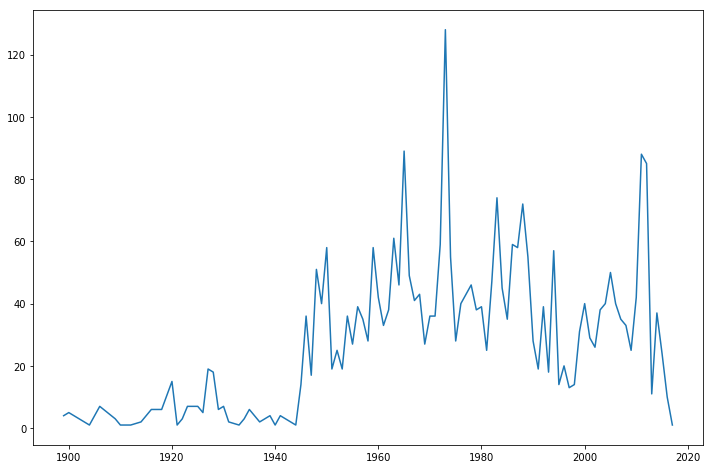

In [39]:
plt.figure(figsize=(12,8))
plt.plot(df1[df1.installation_year < 9999].groupby('installation_year')['spill_street_address'].count())

In [40]:
df1.year.value_counts().sort_index()

2009    383
2010    538
2011    354
2012    374
2013    282
2014    196
2015    263
2016    304
2017    193
2018    259
2019     37
Name: year, dtype: int64

### Spills by year.

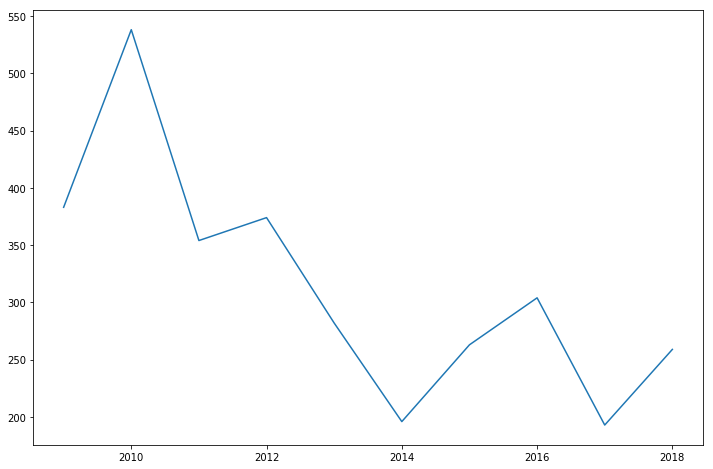

In [41]:
plt.figure(figsize=(12,8))
plt.plot(df1[df1.year < 2019].groupby('year')['spill_street_address'].count())

### All observations grouped by month of the year.

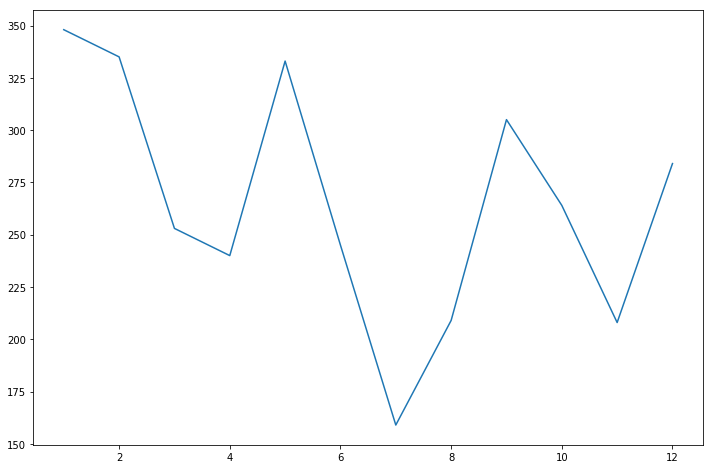

In [42]:
plt.figure(figsize=(12,8))
plt.plot(df1.groupby('month')['spill_street_address'].count())

### Colder months mean more grease clogs. Grease solidifies in colder temperatures.

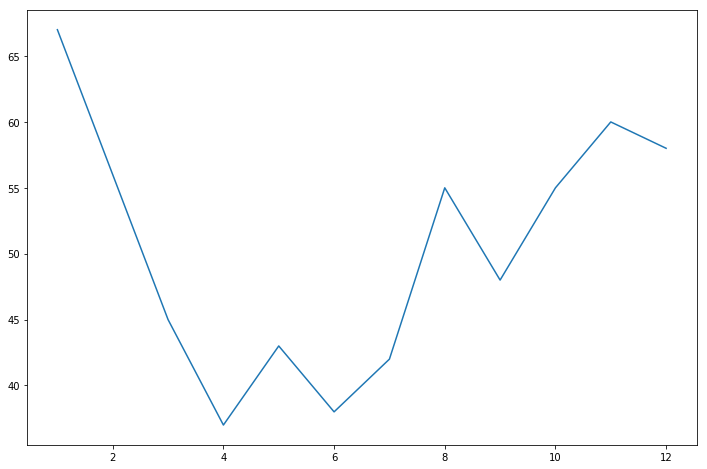

In [43]:
plt.figure(figsize=(12,8))
plt.plot(df1[(df1.root_cause == 'grease') & (df1.year < 2019)].groupby('month')['spill_street_address'].count())